# ENCODE bigWig analysis questions

__Team members:__ Yixin Zhu, Yingqi Zhang, Yue Huang

To ensure reproducibility, conda enviroment `environment.yml` is recommended to be used

In [1]:
import colorcet as cc
import pandas as pd
import numpy as np
import seaborn as sns
import  sklearn.decomposition
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from hwutils import *
from hwutils2 import *

In [2]:
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

## Question 1

In [3]:
#The original metadata dataframe is too large and contains too many irrelavent information, thus here we keep only the ones we need
metadata_filter = bigwig_metadata[bigwig_metadata['File accession'].isin(df.columns.values.tolist())]
metadata_filter = metadata_filter.reset_index()
metadata_filter = metadata_filter.drop("index", 1)
metadata_filter = metadata_filter.drop("Unnamed: 0", 1)
metadata_filter['Output type'].value_counts()

fold change over control    200
Name: Output type, dtype: int64

Text(69.0, 0.5, 'Positions on Chr 10')

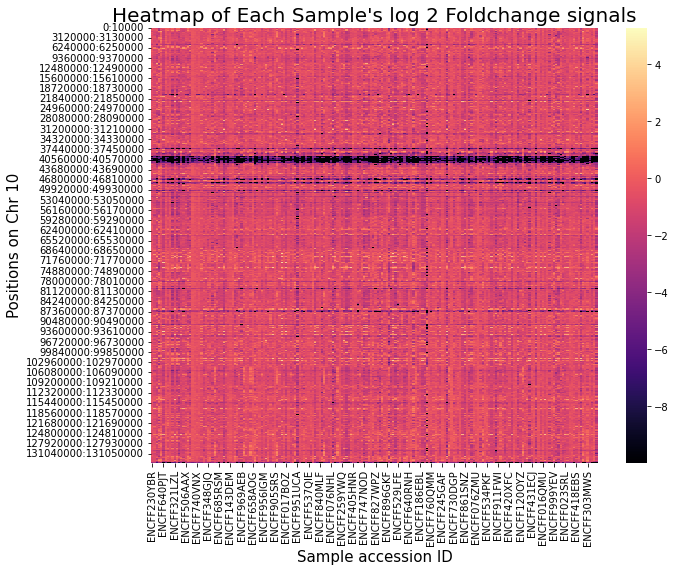

In [4]:
#Plotting the heatmap of the 200 signals
# heatmap side bar 
df_heat = df.iloc[:,3:]
df_heat += 0.001
df_heat.index = df.iloc[:,1].astype(str) + ':' + df.iloc[:,2].astype(str)
df_heat = np.log2(df_heat)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_heat, ax=ax,  cmap="magma")
plt.title("Heatmap of Each Sample's log 2 Foldchange signals", fontsize = 20) # title with fontsize 20
plt.xlabel('Sample accession ID', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Positions on Chr 10', fontsize = 15) # y-axis label with fontsize 15

In human, centromeres of chr10 are located around 40Mb. A dip in chip-seq signal near the centromere region is due to the lack of centromere reference sequences in the human reference genome. The centromere contains highly repetitive regions, making it difficult to assemble. Only until recently, with the development of long-read sequencing technique, we gained a clearer genomic profile of the centromere. Thus, it is highly possible that the ChIP-seq data used here were aligned to a human genome that excluded centromere sequences, leading to a signal dip around chr10 40Mb. 

## Question 2

Text(0, 0.5, 'PC2 (10.67% varaince expained)')

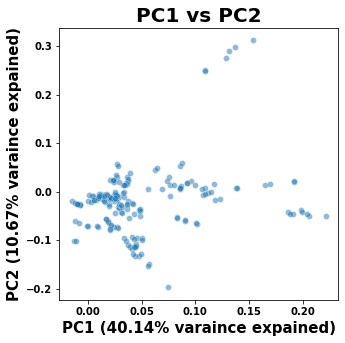

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df.iloc[:,3:])

plot_pca(pca, figsize=(5,5))
plt.title("PC1 vs PC2", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (40.14% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (10.67% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

## Question 3

Text(0, 0.5, 'PC2 (10.67% varaince expained)')

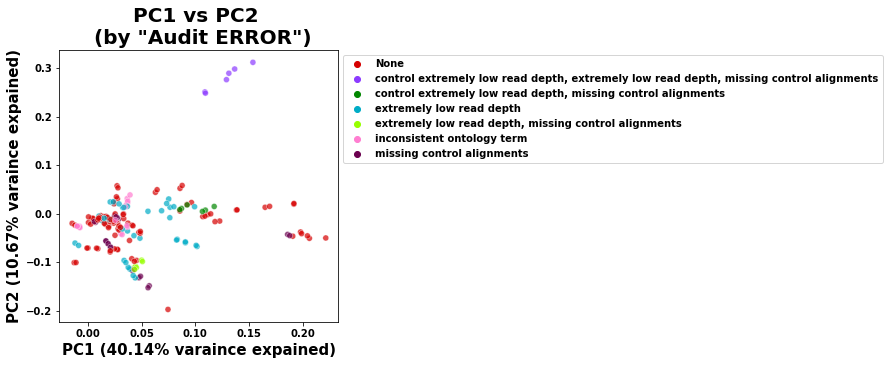

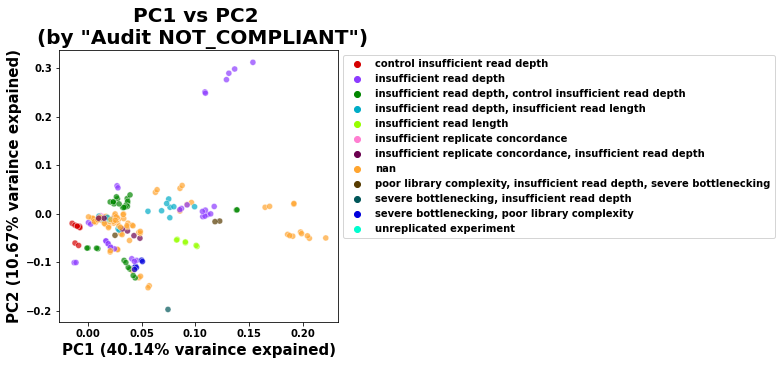

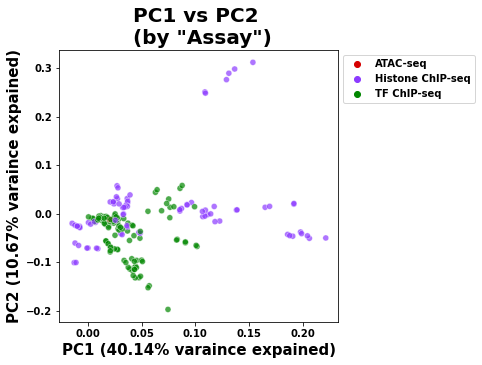

In [6]:
plot_pca( pca , bigwig_metadata=metadata_filter, metadata_label_column='Audit ERROR', figsize=(5,5), alpha=0.7)
plt.title("PC1 vs PC2 \n (by \"Audit ERROR\")", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (40.14% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (10.67% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

plot_pca( pca , bigwig_metadata=metadata_filter, metadata_label_column='Audit NOT_COMPLIANT', figsize=(5,5), alpha=0.7)
plt.title("PC1 vs PC2 \n (by \"Audit NOT_COMPLIANT\")", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (40.14% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (10.67% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

plot_pca( pca , bigwig_metadata=metadata_filter, metadata_label_column='Assay', figsize=(5,5), alpha=0.7)
plt.title("PC1 vs PC2 \n (by \"Assay\")", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (40.14% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (10.67% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15


From the above plots, we believe that column "Audit ERROR" is the most useful for removing outliers. Thus, next we will remove outliers accordingly.

Text(0, 0.5, 'PC2 (10.5% varaince expained)')

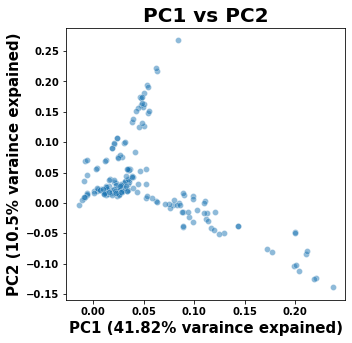

In [7]:
# Filter out all samples with "Audit ERROR" of control extremly low read depth + extremly low read depth + missing control alignment
df_t = df.transpose()
acc_id_Error = metadata_filter[metadata_filter["Audit ERROR"] == "control extremely low read depth, extremely low read depth, missing control alignments"]["File accession"]
df_filtered_t = df_t.drop(df_t[(df_t.index.isin(acc_id_Error))].index)
df_filtered = df_filtered_t.transpose()
pca_filtered = PCA(n_components=2)
pca_filtered.fit(df_filtered.iloc[:,3:])
plot_pca(pca_filtered, figsize=(5,5))
plt.title("PC1 vs PC2", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (41.82% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (10.5% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

In [8]:
metadata_filter_outlier = metadata_filter[metadata_filter['File accession'].isin(df_filtered.columns.values.tolist())]
metadata_filter_outlier = metadata_filter_outlier.reset_index()
metadata_filter_outlier = metadata_filter_outlier.drop("index", 1)

`df_filtered` is now our df with outliers removed
`metadata_filter_outlier` is now our metadata df with outliers removed

## Question 4

Considering the functioning range of of transcription factors and histones, we calculated autocorrelation with the lag set to 10000 bp. We also plotted AutoCorrelation Function (ACF) for several samples to show autocorrelations with different lags.

In [9]:
import statsmodels.api as sm
dfdrop = df_filtered.drop(['chrom', 'start', 'end'], axis=1)  ## drop colums that were not used in calculating auto correlation
dfdrop_trans = np.transpose(dfdrop)
dfdrop_trans['Auto correlation'] = np.nan   ## Initially, set Auto correlation column to NA

for i in range (len(dfdrop_trans)):
    autovalue = pd.DataFrame(sm.tsa.acf(dfdrop_trans.iloc[i].drop(['Auto correlation'], axis=0), nlags=1)).iloc[1,0]   ## Calculate autocorrelation with lag=10000 bp
    label = dfdrop_trans.index.values[i] 
    dfdrop_trans.at[label,'Auto correlation'] = autovalue
    
dfdrop_trans['File accession'] = dfdrop_trans.index
auto_res = pd.merge(dfdrop_trans[['File accession', 'Auto correlation']],    ## merge autocorrelation results with metadata
                      metadata_filter_outlier[['File accession', 'Biosample term name', 'Biosample type', 'Assay', 'Experiment target']], 
                      on ='File accession', 
                      how ='inner')

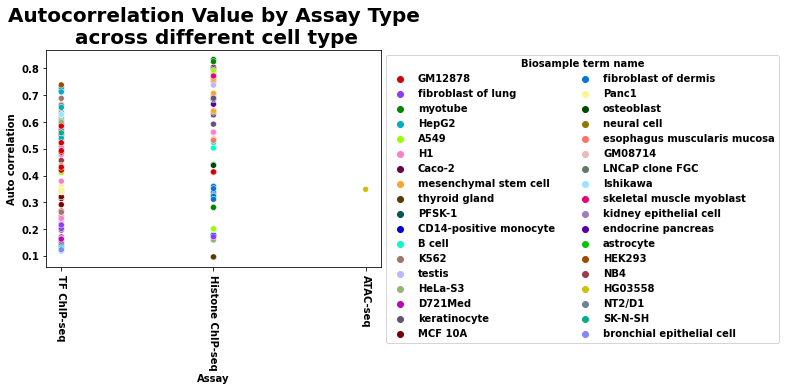

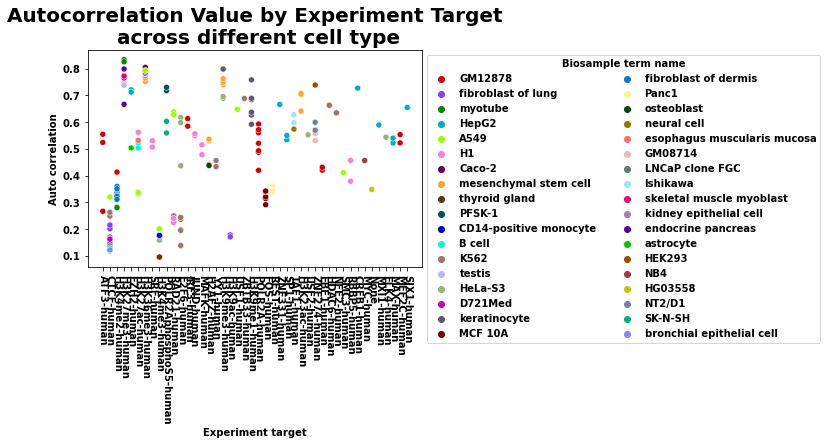

In [10]:
import pandas as pd
import seaborn as sns
palette = sns.color_palette(cc.glasbey, n_colors=36)
##Plot autocorrelation against assay, color by cell types
ax = sns.scatterplot('Assay', 'Auto correlation', data=auto_res, hue='Biosample term name', palette=palette)
plt.xticks(rotation=270)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=math.ceil(2))
plt.title("Autocorrelation Value by Assay Type\n across different cell type", fontsize = 20, weight="bold") # title with fontsize 20
plt.show()

##Plot autocorrelation against experiment target, color by cell types
ax = sns.scatterplot('Experiment target', 'Auto correlation', data=auto_res, hue='Biosample term name', palette=palette)
plt.xticks(rotation=270)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=math.ceil(2))
plt.title("Autocorrelation Value by Experiment Target\n across different cell type", fontsize = 20, weight="bold") # title with fontsize 20
plt.show()

As the first plot shown above, there is only one ATAC-seq sample and its autocorrelation is low, which indicates that it shows narrow patterns. For TF-ChIP seq and Histone-CHIP seq, there are variations of autocorrelations (or say, pattern types) across different cell types. <br><br>
As the second plot shown above, some target shows broard patterns (high autocorrelation) while some show narrow patterns. For some targets, the patterns are consistent across cell types (indicated by colors); while for some targets, the patterns are not always consistent across cell types. <br><br>
Let's look at some exaples: H3K36me3-human shows broad patterns (high autocorrelation) and it's consistent across different cell types; while H3K9ac-human shows narrow patterns (low autocorrelation) and it's also consistent across different cell types.**However,** RAD21-human shows different patterns accross different types. RAD21-human shows broad patterns for A549 cell line while narrow patterns for H1 and K562 cell lines.

In [11]:
auto_res.loc[auto_res['Experiment target'] == 'H3K36me3-human'].groupby("Biosample term name").mean()

,Auto correlation
Biosample term name,
A549,0.796605
Caco-2,0.800681
kidney epithelial cell,0.777713
mesenchymal stem cell,0.775117


In [12]:
auto_res.loc[auto_res['Experiment target'] == 'H3K9ac-human'].groupby("Biosample term name").mean()

,Auto correlation
Biosample term name,
fibroblast of lung,0.174962


In [13]:
auto_res.loc[auto_res['Experiment target'] == 'RAD21-human'].groupby("Biosample term name").mean()

,Auto correlation
Biosample term name,
A549,0.632836
H1,0.232512
K562,0.250028


__Bonus:__ we plotted one broad pattern example (ENCFF263DJX targetting H3K36me3-human) and two narrow pattern examples (ENCFF023SRL targetting H3K9ac-human, and ENCFF506AAX targetting RAD21-human) using ACF as a sanity check.

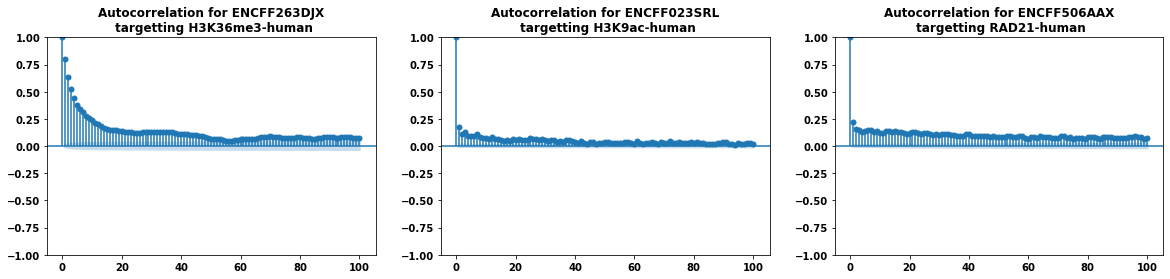

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

dfdrop = df_filtered.drop(['chrom', 'start', 'end'], axis=1)  ## drop colums that were not used in calculating auto correlation
dfdrop1=dfdrop.loc[:, 'ENCFF263DJX']
plot_acf(dfdrop1, lags=100, ax=ax1)
ax1.set_title('Autocorrelation for ENCFF263DJX\n targetting H3K36me3-human', weight="bold")

dfdrop = df_filtered.drop(['chrom', 'start', 'end'], axis=1)  ## drop colums that were not used in calculating auto correlation
dfdrop1=dfdrop.loc[:, 'ENCFF023SRL']
plot_acf(dfdrop1, lags=100, ax=ax2)
ax2.set_title("Autocorrelation for ENCFF023SRL\n targetting H3K9ac-human", weight="bold") # title with fontsize 20


dfdrop = df_filtered.drop(['chrom', 'start', 'end'], axis=1)  ## drop colums that were not used in calculating auto correlation
dfdrop1=dfdrop.loc[:, 'ENCFF506AAX']
plot_acf(dfdrop1, lags=100, ax=ax3)
ax3.set_title("Autocorrelation for ENCFF506AAX\n targetting RAD21-human", weight="bold") # title with fontsize 20
plt.show()

From the first plot above, we can see autocorrelation drops slowly when lag increases, which indicates broad patterns. For the next two plots above, we can see autocorrelation drops fast when lag increases, which indicates narrow patterns. **Sanity check passed!**

Text(0, 0.5, 'PC2 (10.5% varaince expained)')

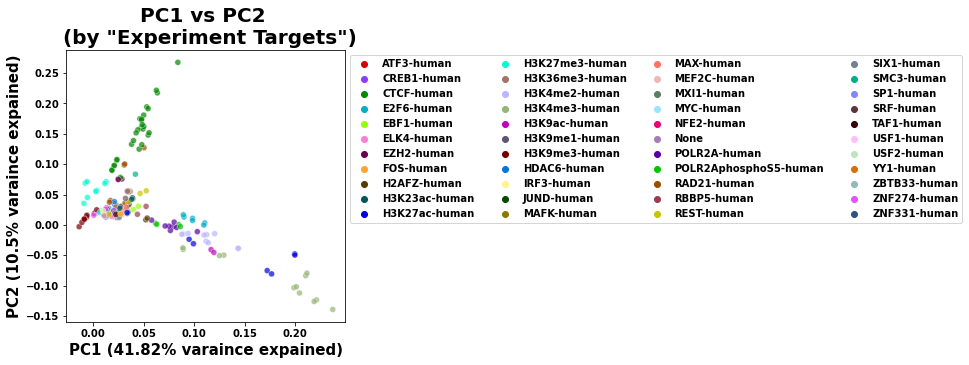

In [15]:
plot_pca( pca_filtered , bigwig_metadata=metadata_filter, metadata_label_column='Experiment target', figsize=(5,5), alpha=0.7)
plt.title("PC1 vs PC2 \n (by \"Experiment Targets\")", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (41.82% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (10.5% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

The patterns (narrow/broad) have some relations with patterns seen in PCA (shown above). For example, CTCF-human and H3K4me3-human both have very narrow patterns (low autocorrelations) as compared to other targets, and they are also separated from other points in the PCA plot shwon above.

In [16]:
auto_res.loc[auto_res['Experiment target'] == 'CTCF-human'].mean()

Auto correlation    0.168747
dtype: float64

In [17]:
auto_res.loc[auto_res['Experiment target'] == 'H3K4me3-human'].mean()

Auto correlation    0.163784
dtype: float64

## Question 5

Text(0, 0.5, 'PC2 (10.5% varaince expained)')

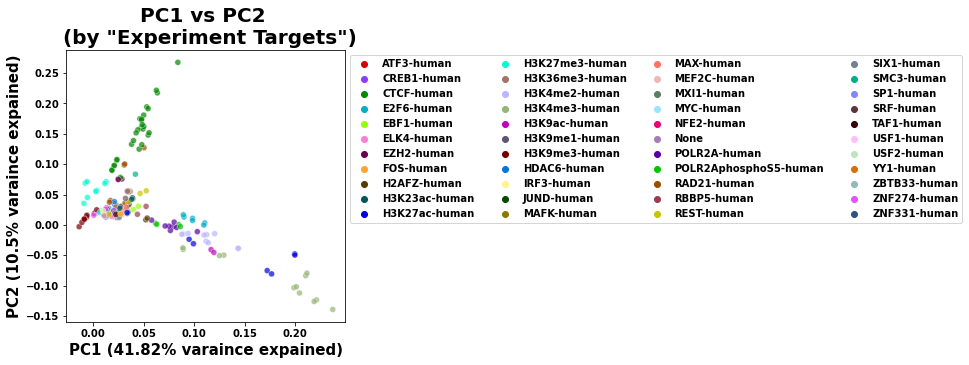

In [18]:
plot_pca(pca_filtered , bigwig_metadata=metadata_filter, metadata_label_column='Experiment target', figsize=(5,5), alpha=0.7)
plt.title("PC1 vs PC2 \n (by \"Experiment Targets\")", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (41.82% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (10.5% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

In [19]:
auto_res.loc[auto_res['Experiment target'] == 'H3K36me3-human']['Biosample term name'].value_counts()

mesenchymal stem cell     6
Caco-2                    2
A549                      2
kidney epithelial cell    2
Name: Biosample term name, dtype: int64

In [20]:
auto_res.loc[auto_res['Experiment target'] == 'H3K9me3-human']['Biosample term name'].value_counts()

mesenchymal stem cell    6
HeLa-S3                  2
keratinocyte             2
Name: Biosample term name, dtype: int64

In [21]:
def pca_plot_celltype(pca, df, celltype):
    pca_components = pd.DataFrame(pca.components_)
    pca_components.columns = df.columns[3:]
    pca_components_t = pca_components.transpose()
    acc_id_Error = metadata_filter[metadata_filter["Biosample term name"] != celltype]["File accession"]
    df_filtered_H3K9me3 = pca_components_t.drop(pca_components_t[(pca_components_t.index.isin(acc_id_Error))].index, 0)
    labels = [metadata_filter.query(
                        "`File accession`==@ file_accession ").loc[:,"Biosample term name"].values[0] + "_" + metadata_filter.query(
                        "`File accession`==@ file_accession ").loc[:,"Experiment target"].values[0]
                      for file_accession in pca_components_t.index]

    for i in range(0, len(labels)):
        if labels[i] != celltype + "_H3K9me3-human" and labels[i] != celltype + "_H3K36me3-human":
            labels[i] = "others"
    fig, ax = plt.subplots(figsize=(5,5))


    colors = ["#FF9505",  "#40531B", "#DADADA"]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))
    hue_order = [celltype + "_H3K9me3-human", celltype + "_H3K36me3-human", 'others']

    sns.scatterplot(pca_components_t[0],
                    pca_components_t[1],
                    hue = labels,
                    alpha=0.8, hue_order=hue_order)

    legend_labels, _= ax.get_legend_handles_labels()
    ax.legend(legend_labels, np.unique(labels), bbox_to_anchor=(1,1))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=math.ceil(3/12))

    plt.title("PC1 vs PC2 \n H3K9me3 and H3K36me3 across " + celltype, fontsize = 20, weight="bold") # title with fontsize 20
    plt.xlabel('PC1 (41.82% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
    plt.ylabel('PC2 (10.5% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

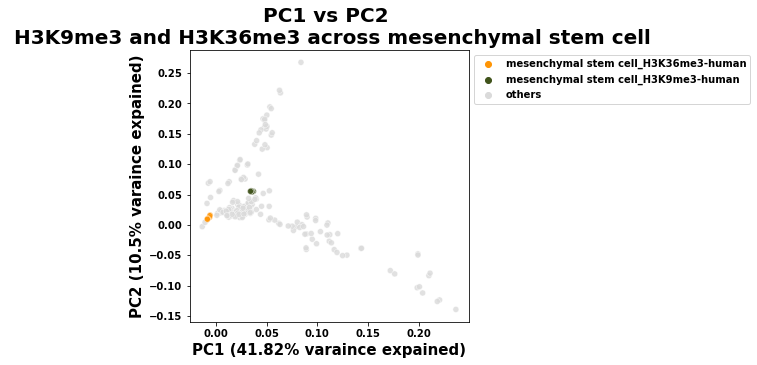

In [22]:
pca_plot_celltype(pca_filtered, df_filtered, "mesenchymal stem cell")

We used the example of __H3K9me3-human__ and __H3K36me3-human__ to answer this question. These two targets for mesenchymal stem cell are relatively close to each other in the space of PC1 and PC2.<br><br> 
In Barral's paper, they characterized the localization and the function of a heterochromatin, which is simultaneously enriched in __H3K9me3__ mark and in __H3K36me3__ mark. They also identified thousands of dual domains in mouse embryonic stem cells that rely on the histone methyltransferases SET domain bifurcated 1 (SETDB1) and nuclear set domain (NSD)-containing proteins to generate H3K9me3 and H3K36me3. Furthermore, after removing SETDB1, dual domains lose both marks. <br><br>
This example shows that proximities in PCA could mean that these factors share some common pathways (and are co-regulated by some common upstream factors in the pathway), or they function together in some biological process. <br><br>

Citation: 
> Barral, Amandine, et al. "SETDB1/NSD-dependent H3K9me3/H3K36me3 dual heterochromatin maintains gene expression profiles by bookmarking poised enhancers." Molecular cell 82.4 (2022): 816-832. https://doi.org/10.1016/j.molcel.2021.12.037

## Question 6
- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


To make normalizing meaningful, centromere region has to be removed before normalizing. According to the information online (https://en.wikipedia.org/wiki/Chromosome_10) which also relates to our heatmap result (the dark region around 39.8 Mbp), the centromere region is roughly 38 Mbp to 41.6 Mbp. Thus, row 3800 to 4159 has to be removed.

In [102]:
from sklearn import preprocessing
import numpy as np
import sys

df_drop = df.drop(['chrom', 'start', 'end'], axis=1)
df_drop=df_drop.drop(index=range(3800, 4160, 1))     ## Remove centromere
scaler = preprocessing.StandardScaler().fit(df_drop)   ## Normalize variance per track
df_normalized = scaler.transform(df_drop)
df_normalized = pd.DataFrame(df_normalized)
df_normalized = pd.DataFrame(df_normalized.values, columns=df_drop.columns)
#df_normalized

[0.30655008 0.09818916]


Text(0, 0.5, 'PC2 (9.82% varaince expained)')

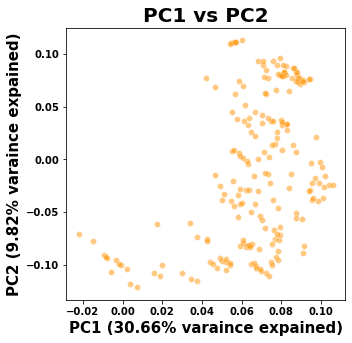

In [103]:
from sklearn.decomposition import PCA
pca_normalized = PCA(n_components=2)
pca_normalized.fit(df_normalized)

print(pca_normalized.explained_variance_ratio_)
from hwutils import *
plot_pca(pca_normalized, figsize=(5,5))
plt.title("PC1 vs PC2", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (30.66% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (9.82% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15


Text(0, 0.5, 'PC2 (9.82% varaince expained)')

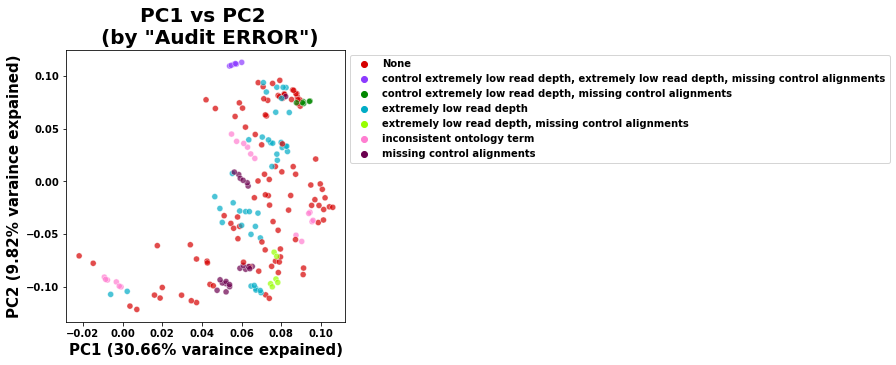

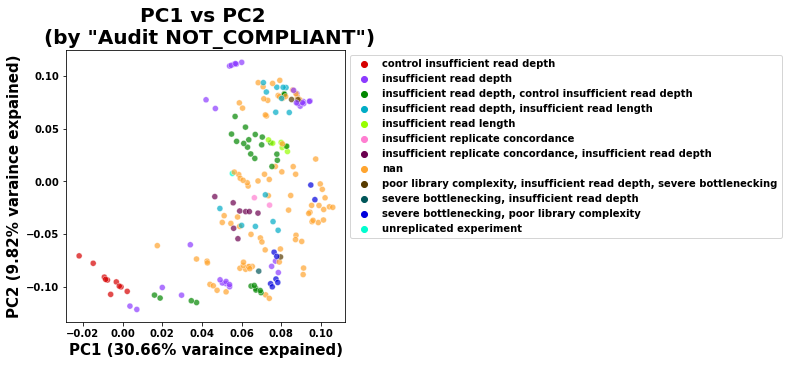

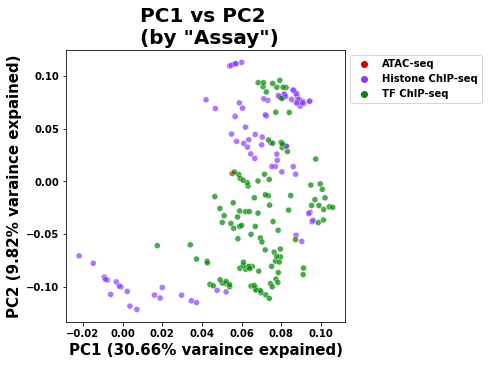

In [104]:
plot_pca( pca_normalized , bigwig_metadata=metadata_filter, metadata_label_column='Audit ERROR', figsize=(5,5), alpha=0.7)
plt.title("PC1 vs PC2 \n (by \"Audit ERROR\")", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (30.66% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (9.82% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

plot_pca( pca_normalized , bigwig_metadata=metadata_filter, metadata_label_column='Audit NOT_COMPLIANT', figsize=(5,5), alpha=0.7)
plt.title("PC1 vs PC2 \n (by \"Audit NOT_COMPLIANT\")", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (30.66% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (9.82% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

plot_pca( pca_normalized , bigwig_metadata=metadata_filter, metadata_label_column='Assay', figsize=(5,5), alpha=0.7)
plt.title("PC1 vs PC2 \n (by \"Assay\")", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (30.66% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (9.82% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15


As shown above, no outliers need to be removed after preprocessing.

Text(0, 0.5, 'PC2 (9.82% varaince expained)')

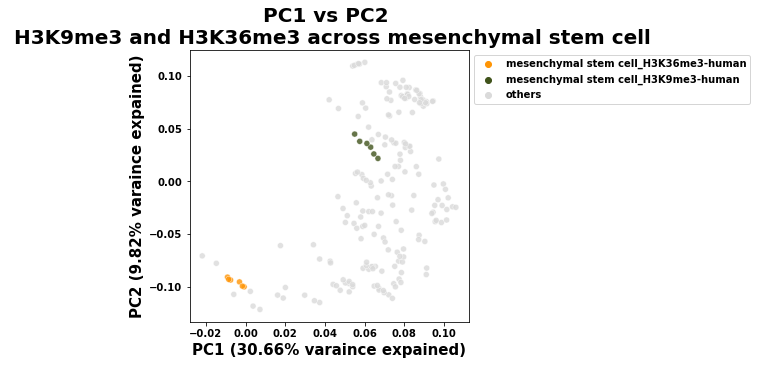

In [78]:
pca_components = pd.DataFrame(pca_normalized.components_)
pca_components.columns = df_normalized.columns
pca_components_t = pca_components.transpose()
acc_id_Error = metadata_filter[metadata_filter["Biosample term name"] != "mesenchymal stem cell"]["File accession"]
df_filtered_H3K9me3 = pca_components_t.drop(pca_components_t[(pca_components_t.index.isin(acc_id_Error))].index, 0)
labels = [metadata_filter.query(
                    "`File accession`==@ file_accession ").loc[:,"Biosample term name"].values[0] + "_" + metadata_filter.query(
                    "`File accession`==@ file_accession ").loc[:,"Experiment target"].values[0]
                  for file_accession in pca_components_t.index]

for i in range(0, len(labels)):
    if labels[i] != "mesenchymal stem cell_H3K9me3-human" and labels[i] != "mesenchymal stem cell_H3K36me3-human":
        labels[i] = "others"
fig, ax = plt.subplots(figsize=(5,5))


colors = ["#FF9505",  "#40531B", "#DADADA"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
hue_order = ['mesenchymal stem cell_H3K9me3-human', 'mesenchymal stem cell_H3K36me3-human', 'others']

sns.scatterplot(pca_components_t[0],
                pca_components_t[1],
                hue = labels,
                alpha=0.8, hue_order=hue_order)

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, np.unique(labels), bbox_to_anchor=(1,1))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=math.ceil(3/12))

plt.title("PC1 vs PC2 \n H3K9me3 and H3K36me3 across mesenchymal stem cell", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (30.66% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (9.82% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

In [105]:
pca_plot_celltype(pca_normalized, df_normalized, "mesenchymal stem cell")

TypeError: pca_plot_celltype() takes 2 positional arguments but 3 were given

In [27]:
import statsmodels.api as sm

dfdrop_trans = np.transpose(df_normalized)
dfdrop_trans['Auto correlation'] = np.nan   ## Initially, set Auto correlation column to NA

for i in range (len(dfdrop_trans)):
    autovalue = pd.DataFrame(sm.tsa.acf(dfdrop_trans.iloc[i].drop(['Auto correlation'], axis=0), nlags=1)).iloc[1,0]   ## Calculate autocorrelation with lag=10000 bp
    label = dfdrop_trans.index.values[i] 
    dfdrop_trans.at[label,'Auto correlation'] = autovalue
    
dfdrop_trans['File accession'] = dfdrop_trans.index
auto_res_normalized = pd.merge(dfdrop_trans[['File accession', 'Auto correlation']],    ## merge autocorrelation results with metadata
                      metadata_filter[['File accession', 'Biosample term name', 'Biosample type', 'Assay', 'Experiment target']], 
                      on ='File accession', 
                      how ='inner')
#auto_res_normalized  ##display the merged dataframe

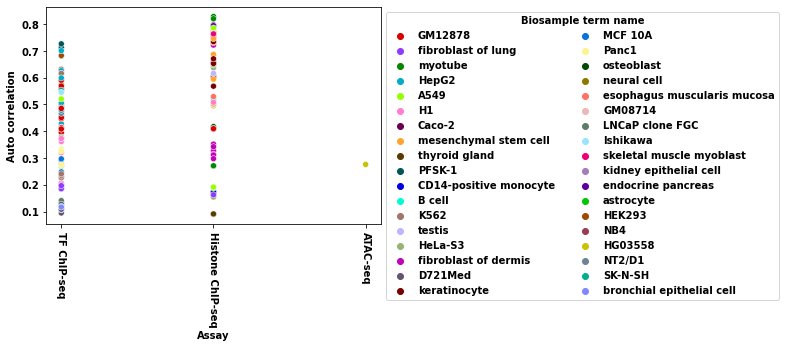

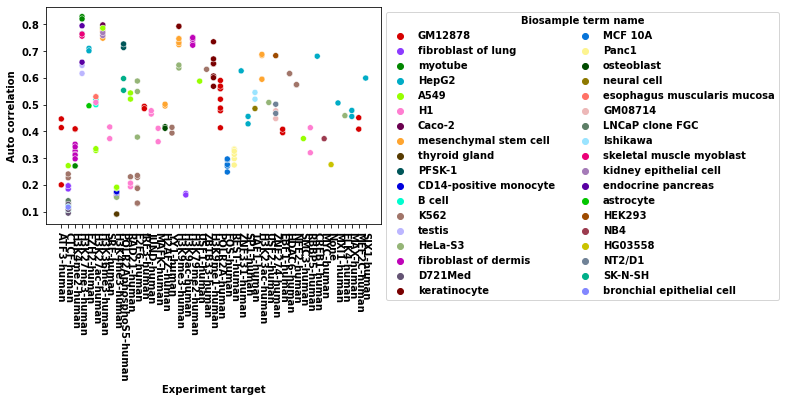

In [28]:
import pandas as pd
import seaborn as sns
palette = sns.color_palette(cc.glasbey, n_colors=36)

##Plot autocorrelation against assay, color by cell types
ax = sns.scatterplot('Assay', 'Auto correlation', data=auto_res_normalized, hue='Biosample term name', palette=palette)
plt.xticks(rotation=270)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=math.ceil(2))
plt.show()

##Plot autocorrelation against experiment target, color by cell types
ax = sns.scatterplot('Experiment target', 'Auto correlation', data=auto_res_normalized, hue='Biosample term name', palette=palette)
plt.xticks(rotation=270)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=math.ceil(2))
plt.show()

After preprocessing, PCA clustering became different as compared to the version without preprocessing. No outliers need to be removed after preprocessing. H3K9me3-human and H3K36me3-human are relatively far from each other (compared to other targets) in the PCA plot after preprocessing.  However, the absolute distance between H3K9me3-human and H3K36me3-human remains similar before and after preprocessing. <br><br>
Autocorrelation results are similiar before and after preprocessing.

## Question 7
- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


[0.40137272 0.10670343 0.08727222 0.04671352 0.04249061 0.03946426
 0.0293033  0.02255293 0.02220868 0.01724517 0.01647486 0.01226426
 0.01203222 0.01039582 0.00974744 0.0094192  0.00793443 0.00682449
 0.00640103 0.00558243]


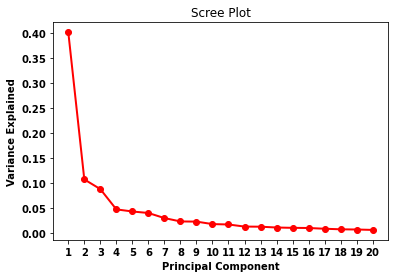

In [29]:
pca = PCA(n_components=20)
pca.fit(df.iloc[:,3:])
print(pca.explained_variance_ratio_)
# Variance associated with individual PC
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
a = plt.xticks(ticks = PC_values, labels = PC_values)

[0.40137272 0.50807615 0.59534837 0.64206189 0.6845525  0.72401676
 0.75332007 0.775873   0.79808168 0.81532685 0.83180171 0.84406597
 0.85609819 0.86649401 0.87624145 0.88566065 0.89359508 0.90041957
 0.9068206  0.91240304]


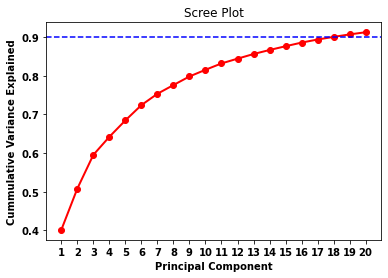

In [30]:
# Now looking at cumulative variance to address to question itself
cum_variance = pca.explained_variance_ratio_.cumsum()
print(cum_variance)
plt.plot(PC_values, cum_variance, 'o-', linewidth=2, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cummulative Variance Explained')
plt.xticks(ticks = PC_values, labels = PC_values)
plt.axhline(y=0.9, color='b', linestyle='--')

Because y=0.9 crosses the value corresponding to PC 18, so we need 18 principle components to explain at least 90% of variance (which is a lot!)

## Question 8
- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


Text(0.5, 1.0, '2D MDS plot')

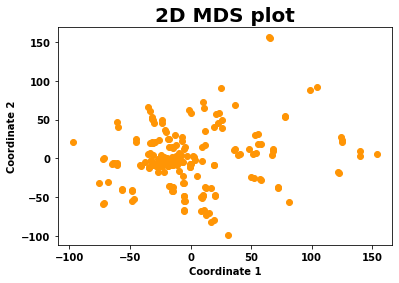

In [31]:
df_filtered_trans = df_filtered.transpose()
mds = MDS(random_state=0) # n_components is defaulted to 2
scaled_df = mds.fit_transform(df_filtered_trans.iloc[3:,:])
scaled_df.shape
plt.scatter(scaled_df[:,0],scaled_df[:,1])
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('2D MDS plot', fontsize = 20, weight="bold")

[0.41816447 0.10499798]


Text(0, 0.5, 'PC2 (10.5% varaince expained)')

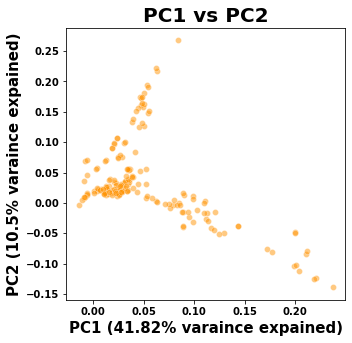

In [32]:
pca_comp = PCA(n_components=2)
pca_comp.fit(df_filtered.iloc[:,3:])
print(pca_comp.explained_variance_ratio_)
plot_pca(pca_comp, figsize=(5,5))
plt.title("PC1 vs PC2", fontsize = 20, weight="bold") # title with fontsize 20
plt.xlabel('PC1 (41.82% varaince expained)', fontsize = 15, weight="bold") # x-axis label with fontsize 15
plt.ylabel('PC2 (10.5% varaince expained)', fontsize = 15, weight="bold") # y-axis label with fontsize 15

(array([45., 27., 18., 13., 10.,  9., 12., 17., 11., 32.]),
 array([-0.99717218, -0.79860794, -0.60004371, -0.40147947, -0.20291523,
        -0.00435099,  0.19421325,  0.39277749,  0.59134173,  0.78990597,
         0.98847021]),
 <BarContainer object of 10 artists>)

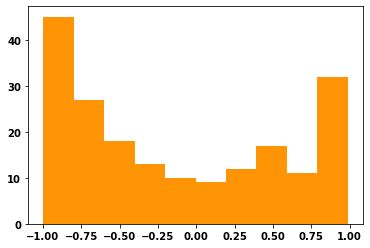

In [33]:
from numpy.linalg import norm
pca_df = np.transpose(pca_comp.components_)
cosine = np.sum(scaled_df * pca_df, axis=1)/(norm(scaled_df, axis=1) * norm(pca_df, axis=1))
cosine.shape
ave_cs = np.mean(cosine) #-0.1403924664378631 
plt.hist(cosine)

MDS maps points from high dimensional space down to low dimensional space with the goal of preserving the distances between those points as much as possible. In comparison, PCA looks for features that best preserve the variance of data by minimizing residual squared.

We used cosine similarity to compare the similarity of every point pair from PCA and MDS. The results are shown as the histogram above.

## Question 9
- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


NMF could be useful in analyzing this dataset. The main reason is that gene expression data needs to be nonnegative to be biologically meaningful, thus satisfying the requirement for non-negative matrices for NMF analysis. NMF is a relatively new approach for gene expression analysis but has been used in studies on different organisms and tissue types. One aspect that NMF is particularly useful is that it allows researchers to find ‘metagenes’ from expression profiles, which may be directly related to biological pathways and disease entities.

> Frigyesi, A., & Höglund, M. (2008). Non-negative matrix factorization for the analysis of complex gene expression data: identification of clinically relevant tumor subtypes. Cancer informatics, 6, CIN-S606.

> Lin, X., & Boutros, P. C. (2020). Optimization and expansion of non-negative matrix factorization. BMC bioinformatics, 21(1), 1-10.